In [5]:
import math
from inspect import isfunction
from functools import partial

# %matplotlib inline
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from einops import rearrange

import torch
from torch import nn, einsum
import torch.nn.functional as F

# https://huggingface.co/blog/annotated-diffusion

In [6]:
from torchvision import transforms
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST

# Convert to tensor and normalize between -1 and 1
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])


# Load mnist
mnist = MNIST('./data', train=True, download=True, transform=transform)
data_loader = DataLoader(mnist, batch_size=128, shuffle=True)

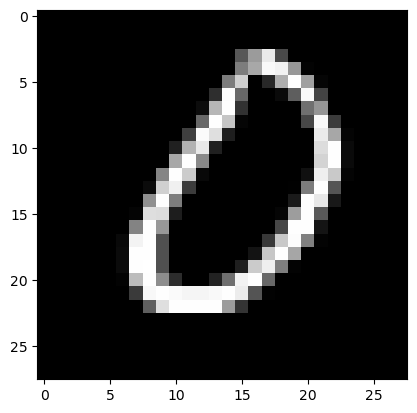

In [7]:
image = next(iter(data_loader))[0][0]
plt.imshow(image.squeeze(), cmap='gray');

In [8]:
T = 200
def linear_beta_schedule(timesteps):
    beta_start = 0.0001
    beta_end = 0.02
    return torch.linspace(beta_start, beta_end, timesteps)

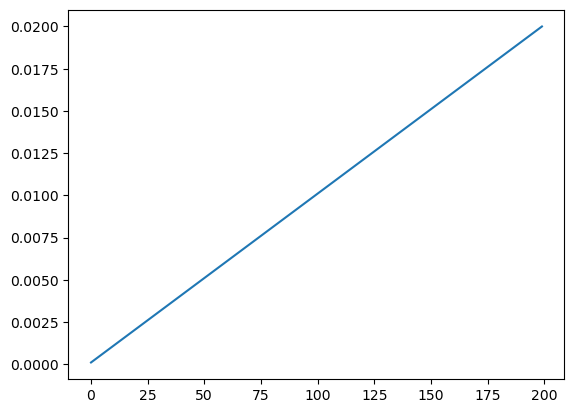

In [9]:
betas = linear_beta_schedule(T)
plt.plot(betas);

Noise step: 196


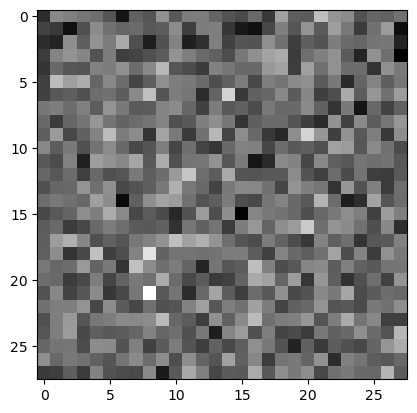

In [10]:
# Extract appropriate t index from batch of alphas (?)
def extract(a: torch.tensor, t: torch.tensor, x_shape: torch.tensor):
    batch_size = t.shape[0]
    out = a.gather(-1, t.cpu())
    return out.reshape(batch_size, *((1,) * (len(x_shape) - 1))).to(t.device)

def q_sample(x_start, t, betas):
    # Move outside function?
    alphas = 1.0 - betas
    alphas_cumprod = torch.cumprod(alphas, dim=0)
    alphas_cumprod_prev = F.pad(alphas_cumprod[:-1], (1,0), value=1.0)
    sqrt_recip_alphas = torch.sqrt(1.0 / alphas)

    sqrt_alphas_cumprod = torch.sqrt(alphas_cumprod)
    sqrt_one_minus_alphas_cumprod = torch.sqrt(1.0 - alphas_cumprod)

    noise = torch.randn_like(x_start)

    sqrt_alphas_cumprod_t = extract(sqrt_alphas_cumprod, t, x_start.shape)
    sqrt_one_minus_alphas_cumprod_t = extract(
        sqrt_one_minus_alphas_cumprod, t, x_start.shape)
    
    return x_start * sqrt_alphas_cumprod_t + noise * sqrt_one_minus_alphas_cumprod_t

idx = torch.randint(0, T, (1,))
img_noisy = q_sample(image, torch.tensor([idx]), betas)
print(f"Noise step: {idx.item()}")
plt.imshow(img_noisy.squeeze(), cmap='gray');

In [11]:
# Define some useful helper stuff

class Residual(nn.Module):
    def __init__(self, fn):
        super().__init__()
        self.fn = fn

    def forward(self, x, *args, **kwargs):
        return x + self.fn(x, *args, **kwargs)

def default(value, default):
    if value is not None:
        return value
    
    return default() if isfunction(default) else default

def Upsample(dim):
    return nn.ConvTranspose2d(dim, dim, kernel_size=4, stride=2, padding=1)

def Downsample(dim):
    return nn.Conv2d(dim, dim, kernel_size=4, stride=2, padding=1)

In [12]:
class SinusoidalPositionEmbeddongs(nn.Module):
    """
    Class for time embedding a batch of time steps
    into a tensor of shape (batch_size, dim)
    """
    def __init__(self, dim: int):
        super().__init__()
        self.dim = dim

    def forward(self, time: torch.tensor, max_period: int = 10_000):
        # time: (batch_size, 1)
        # embeddings: (batch_size, dim)

        assert time.dim() == 2 and time.shape[1] == 1

        device = time.device
        half_dim = self.dim // 2
        emb = math.log(10000) / (half_dim - 1)
        emb = torch.exp(torch.arange(half_dim, device=device) * -emb)
        emb = time[:, None] * emb[None, :]
        emb = torch.cat((emb.sin(), emb.cos()), dim=-1)
        
        return emb


torch.Size([30, 1])
torch.Size([30, 1, 128])


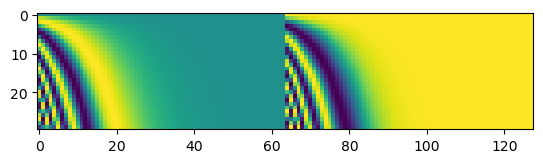

In [14]:
t = torch.arange(0, 30).unsqueeze(-1)
print(t.shape)
sinusoidal_embedding = SinusoidalPositionEmbeddongs(128)
emb = sinusoidal_embedding(t)
print(emb.shape)

# plot the embeddings
plt.imshow(emb.view(-1, 128).detach().numpy());

In [15]:
# Blocks for U-net
class Block(nn.Module):
    def __init__(self, dim, dim_out, groups=8):
        super().__init__()
        self.proj = nn.Conv2d(dim, dim_out, kernel_size=3, padding=1)
        self.norm = nn.GroupNorm(groups, dim_out)
        self.act = nn.SiLU()

    def forward(self, x, scale_shift: tuple = None):
        x = self.proj(x)
        x = self.norm(x)

        if scale_shift is not None:
            scale, shift = scale_shift
            x = scale * x + shift

        return self.act(x)


class ResBlock(nn.Module):
    def __init__(self, dim, dim_out, time_emb_dim=None, groups=8):
        super().__init__()

        self.mlp = (
            nn.Sequential(nn.SiLU(), nn.Linear(time_emb_dim, dim_out))
            if time_emb_dim is not None
            else None
        )

        self.block1 = Block(dim, dim_out, groups=groups)
        self.block2 = Block(dim_out, dim_out, groups=groups)
        self.res_conv = nn.Conv2d(dim, dim_out, 1) if dim != dim_out else nn.Identity()

    def forward(self, x, time_emb: torch.tensor = None):
        h = self.block1(x)

        if self.mlp is not None and time_emb is not None:
            time_emb = self.mlp(time_emb)
            h = rearrange(time_emb, "b c -> b c 1 1") + h

        h = self.block2(h)
        return h + self.res_conv(x)


class ConvNextBlock(nn.Module):
    def __init__(self, dim, dim_out, time_emb_dim=None, mult=2, norm=True):
        super().__init__()
        self.mlp = (
            nn.Sequential(nn.GELU(), nn.Linear(time_emb_dim, dim_out))
            if time_emb_dim is not None else None
        )

        self.ds_conv = nn.Conv2d(dim, dim, kernel_size=7, padding=3, groups=dim)

        self.net = nn.Sequential(
            nn.GroupNorm(1, dim) if norm else nn.Identity(),
            nn.Conv2d(dim, dim_out * mult, kernel_size=3, padding=1),
            nn.GELU(),
            nn.GroupNorm(1, dim_out * mult),
            nn.Conv2d(dim_out * mult, dim_out, kernel_size=3, padding=1),
        )

        self.res_conv = nn.Conv2d(dim, dim_out, 1) if dim != dim_out else nn.Identity()

    def forward(self, x, time_emb: torch.tensor = None):
        h = self.ds_conv(x)

        if self.mlp is not None and time_emb is not None:
            time_emb = self.mlp(time_emb)
            h = rearrange(time_emb, "b c -> b c 1 1") + h

        h = self.net(h)
        return h + self.res_conv(x)

In [16]:
from torchsummary import summary

resblock = ResBlock(128, 64, time_emb_dim=128)
x = torch.randn(1, 128, 32, 32)
time_emb = torch.randn(1, 128)

resblock(x, time_emb).shape

# print summary of resblock
summary(resblock, (128, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]          73,792
         GroupNorm-2           [-1, 64, 32, 32]             128
              SiLU-3           [-1, 64, 32, 32]               0
             Block-4           [-1, 64, 32, 32]               0
            Conv2d-5           [-1, 64, 32, 32]          36,928
         GroupNorm-6           [-1, 64, 32, 32]             128
              SiLU-7           [-1, 64, 32, 32]               0
             Block-8           [-1, 64, 32, 32]               0
            Conv2d-9           [-1, 64, 32, 32]           8,256
Total params: 119,232
Trainable params: 119,232
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.50
Forward/backward pass size (MB): 4.50
Params size (MB): 0.45
Estimated Total Size (MB): 5.45
-------------------------------------------

In [17]:
class Attention(nn.Module):
    def __init__(self, dim, heads=4, dim_head=32):
        super().__init__()
        self.scale = dim_head ** -0.5
        self.head = heads
        hidden_dim = dim_head * heads
        self.to_qkv = nn.Conv2d(dim, hidden_dim * 3, 1, bias=False)
        self.to_out = nn.Conv2d(hidden_dim, dim, 1)

    def forward(self, x):
        b, c, h, w = x.shape
        
        